<p style="text-align:center">
    <a href="https://skills.network" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo">
    </a>
</p>


# **K Nearest Neighbor**


Estimated time needed: **30** minutes


In this lab, you will learn about and practice the K Nearest Neighbor (KNN) model. KNN is a straightforward but very effective model that can be used for both classification and regression tasks. If the feature space is not very large, KNN can be a high-interpretable model because you can explain and understand how a prediction is made by looking at its nearest neighbors.


We will be using a tumor sample dataset containing lab test results about tumor samples. The objective is to classify whether a tumor is malicious (cancer) or benign. As such, it is a typical binary classification task.


## Objectives


After completing this lab, you will be able to:


* Train KNN models with different neighbor hyper-parameters
* Evaluate KNN models on classification tasks
* Tune the number of neighbors and find the optimized one for a specific task


----


First, let's install `seaborn` for visualization tasks and import required libraries for this lab.


In [1]:
# All Libraries required for this lab are listed below.
# !mamba install -qy pandas==1.3.3 numpy==1.21.2 ipywidgets==7.4.2 scipy==7.4.2 tqdm==4.62.3 matplotlib==3.5.0 seaborn==0.9.0
# Note: If your environment doesn't support "!mamba install", use "!pip install".

# Install necessary libraries
# !pip install pandas
# !pip install numpy
# !pip install matplotlib
# !pip install seaborn
# !pip install scikit-learn

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
# Evaluation metrics related methods
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix, precision_recall_fscore_support, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
# Define a random seed to reproduce any random process
rs = 123

In [4]:
# Ignore any deprecation warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Load and explore the tumor sample dataset


We first load the dataset `tumor.csv` as a Pandas dataframe:


In [5]:
# Read dataset in csv format
dataset_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML241EN-SkillsNetwork/labs/datasets/tumor.csv"
tumor_df = pd.read_csv(dataset_url)

Then, let's quickly take a look at the head of the dataframe.


In [6]:
# Display the head of the dataframe
tumor_df.head()

,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BareNuc,BlandChrom,NormNucl,Mit,Class
0,5,1,1,1,2,1,3,1,1,0
1,5,4,4,5,7,10,3,2,1,0
2,3,1,1,1,2,2,3,1,1,0
3,6,8,8,1,3,4,3,7,1,0
4,4,1,1,3,2,1,3,1,1,0


And, display its columns.


In [7]:
# Display the columns of the dataframe
tumor_df.columns

Index(['Clump', 'UnifSize', 'UnifShape', 'MargAdh', 'SingEpiSize', 'BareNuc',
       'BlandChrom', 'NormNucl', 'Mit', 'Class'],
      dtype='object')

Each observation in this dataset contains lab test results about a tumor sample, such as clump or shapes. Based on these lab test results or features, we want to build a classification model to predict if this tumor sample is malicious (cancer) or benign. The target variable `y` is specified in the `Class` column.


Then, let's split the dataset into input `X` and output `y`:


In [8]:
# Split the dataset into input X and output y
X = tumor_df.iloc[:, :-1]
y = tumor_df.iloc[:, -1:]

And, we first check the statistics summary of features in `X`:


In [9]:
# Check the statistics summary of features in X
X.describe()

,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BareNuc,BlandChrom,NormNucl,Mit
count,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000
mean,4.442167,3.150805,3.215227,2.830161,3.234261,3.544656,3.445095,2.869693,1.603221
std,2.820761,3.065145,2.988581,2.864562,2.223085,3.643857,2.449697,3.052666,1.732674
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000
50%,4.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000
75%,6.000000,5.000000,5.000000,4.000000,4.000000,6.000000,5.000000,4.000000,1.000000
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000


As we can see from the above cell output, all features are numeric and ranged between 1 to 10. This is very convenient as we do not need to scale the feature values as they are already in the same range.


Next, let's check the class distribution of output `y`:


In [10]:
# Check the class distribution of output y
y.value_counts(normalize=True)

,proportion
Class,
0,0.650073
1,0.349927


<Axes: xlabel='Class'>

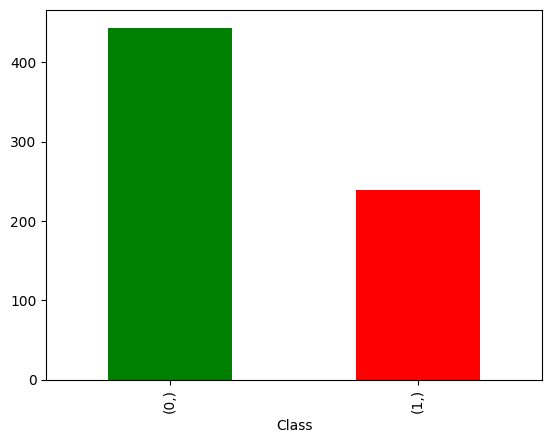

In [11]:
# Plot the class distribution
y.value_counts().plot.bar(color=['green', 'red'])

We have about 65% benign tumors (`Class = 0`) and 35% cancerous tumors (`Class = 1`), which is not a very imbalanced class distribution.


## Split training and testing datasets


In [12]:
# Split 80% as training dataset and 20% as testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state = rs)

## Train and evaluate a KNN classifier with the number of neighbors set to 2


Training a KNN classifier is very similar to training other classifiers in `sklearn`, we first need to define a `KNeighborsClassifier` object. Here we use `n_neighbors=2` argument to specify how many neighbors will be used for prediction, and we keep other arguments to be their default values.


In [13]:
# Define a KNN classifier with `n_neighbors=2`
knn_model = KNeighborsClassifier(n_neighbors=2)

Then we can train the model with `X_train` and `y_train`, and we use ravel() method to convert the data frame `y_train` to a vector.


In [14]:
# Train the model with X_train and y_train
knn_model.fit(X_train, y_train.values.ravel())

KNeighborsClassifier(n_neighbors=2)

And, we can make predictions on the `X_test` dataframe.


In [15]:
# Make predictions on the X_test dataframe
preds = knn_model.predict(X_test)

To evaluate the KNN classifier, we provide a pre-defined method to return the commonly used evaluation metrics such as accuracy, recall, precision, f1score, and so on, based on the true classes in the 'y_test' and model predictions.


In [16]:
# Define a function to evaluate classification metrics
def evaluate_metrics(yt, yp):
    results_pos = {}
    results_pos['accuracy'] = accuracy_score(yt, yp)
    precision, recall, f_beta, _ = precision_recall_fscore_support(yt, yp, average='binary')
    results_pos['recall'] = recall
    results_pos['precision'] = precision
    results_pos['f1score'] = f_beta
    return results_pos

In [17]:
# Evaluate the model with the test data
evaluate_metrics(y_test, preds)

{'accuracy': 0.9416058394160584,
 'recall': 0.875,
 'precision': 0.9545454545454546,
 'f1score': 0.9130434782608695}

We can see that there is a great classification performance on the tumor sample dataset. This means the KNN model can effectively recognize cancerous tumors.
Next, it's your turn to try a different number of neighbors to see if we could get even better performance.


## Coding exercise: Train and evaluate a KNN classifier with number of neighbors set to 5


First, define a KNN classifier with KNeighborsClassifier class:


In [18]:
# Type your code here
# Define a KNN classifier with `n_neighbors=5`
knn_model_5 = KNeighborsClassifier(n_neighbors=5)

Then train the model with `X_train` and `y_train`:


In [19]:
# Type your code here
# Train the model with X_train and y_train
knn_model_5.fit(X_train, y_train.values.ravel())

KNeighborsClassifier()

And, make predictions on `X_test` dataframe:


In [20]:
# Type your code here
# Make predictions on the X_test dataframe
preds_5 = knn_model_5.predict(X_test)

At last, you can evaluate your KNN model with provided `evaluate_metrics()` method.


<details><summary>Click here for a sample solution</summary>

```python
model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_train, y_train.values.ravel())
preds = model.predict(X_test)
evaluate_metrics(y_test, preds)
```

</details>


## Tune the number of neighbors to find the optmized one


OK, you may wonder which `n_neighbors` argument may give you the best classification performance. We can try different `n_neighbors` (the K value) and check which `K` gives the best classification performance.


Here we could try K from 1 to 50, and store the aggregated `f1score` for each k into a list.


In [21]:
# Try K from 1 to 50
max_k = 50
# Create an empty list to store f1score for each k
f1_scores = []

Then we will train 50 KNN classifiers with K ranged from 1 to 50.


In [22]:
# Iterate through different values of k
for k in range(1, max_k + 1):
    # Create a KNN classifier
    knn = KNeighborsClassifier(n_neighbors=k)
    # Train the classifier
    knn = knn.fit(X_train, y_train.values.ravel())
    # Make predictions
    preds = knn.predict(X_test)
    # Evaluate the classifier with f1score and append to the list
    f1 = f1_score(preds, y_test)
    f1_scores.append((k, round(f1_score(y_test, preds), 4)))
# Convert the f1score list to a dataframe
f1_results = pd.DataFrame(f1_scores, columns=['K', 'F1 Score'])
f1_results.set_index('K')

,F1 Score
K,
1,0.9485
2,0.9130
3,0.9485
4,0.9583
5,0.9691
6,0.9583
7,0.9583
8,0.9474
9,0.9474


This is a long list and different to analysis, so let's visualize the list using a linechart.


Text(0.5, 1.0, 'KNN F1 Score')

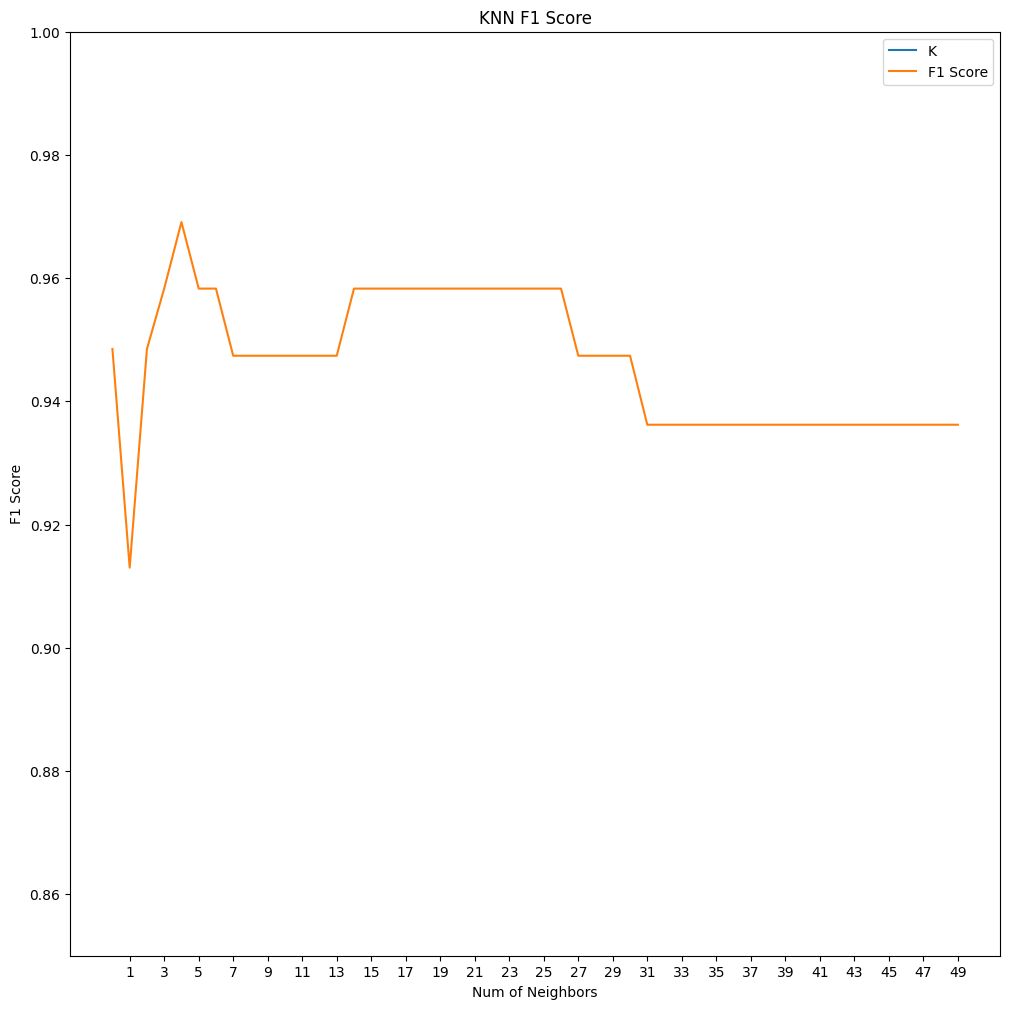

In [23]:
# Plot F1 results
ax = f1_results.plot(figsize=(12, 12))
ax.set(xlabel='Num of Neighbors', ylabel='F1 Score')
ax.set_xticks(range(1, max_k, 2));
plt.ylim((0.85, 1))
plt.title('KNN F1 Score')

As we can see from the F1 score linechart, the best `K` value is 5 with about `0.9691` f1score.


## Next steps


Great! Now you have learned about and applied the KNN model to solve a real-world tumor type classification problem. You also tuned the KNN to find the best K value. Later, you will continue learning other popular classification models with different structures, assumptions, cost functions, and application scenarios.


## Authors


[Yan Luo](https://www.linkedin.com/in/yan-luo-96288783/)


### Other Contributors


<!--## Change Log--!>


<!--|Date (YYYY-MM-DD)|Version|Changed By|Change Description|
|-|-|-|-|
|2021-11-9|1.0|Yan|Created the initial version|
|2022-3-29|1.1|Steve Hord|QA Pass|
--!>


Copyright © 2021 IBM Corporation. All rights reserved.
